# Installing Dependencies

In [ ]:
#Installing all dependencies needed
!pip install labelme opencv-python matplotlib

In [ ]:
#Displays everything installed 
!pip list

# Label Images

In [149]:
#Used for labeling the images in the dataset
!labelme

2024-11-19 16:40:28,400 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\wfenn\.labelmerc


# Build Image Loading Function

## Import Dependencies & Check GPU

In [1]:
# Import TensorFlow for building and running the deep learning model
import tensorflow as tf
# Import OpenCV for image and video processing
import cv2
# Import time module to measure time intervals
import time
# Import json to handle JSON files
import json
# Import os to interact with the operating system 
import os
# Import NumPy for numerical operations
import numpy as np
# Import pyplot from matplotlib for plotting and displaying images
from matplotlib import pyplot as plt
# Import PIL Image for additional image manipulation options
from PIL import Image
# Import datetime to get the current date and time 
from datetime import datetime

In [2]:
# List all physical GPU devices recognized by TensorFlow
gpus = tf.config.experimental.list_physical_devices('GPU')
# Loop through each GPU detected to configure its memory growth setting
for gpu in gpus:
    # Enable memory growth for the GPU to allocate memory as needed, preventing TensorFlow from using all GPU memory at once
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
#Outputs availability of GPU
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## Load Image into Data Pipeline

In [ ]:
#Converting all file types to be the same

# Path to the folder containing background images
input_folder = 'C:\\Users\\wfenn\\ECEN_403\\Data\\Images\\Background'  
output_folder = 'C:\\Users\\wfenn\\ECEN_403\\Data\\Images\\Backgroundv2' 

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate through all files in the input folder
for filename in os.listdir(input_folder):
    # Check if the file is a PNG or JPEG
    if filename.lower().endswith(('.png', '.jpeg', '.jpg')):
        # Open the image
        image_path = os.path.join(input_folder, filename)
        with Image.open(image_path) as img:
            # Convert to RGB (required for JPEG)
            img = img.convert('RGB')
            # Save the image in JPG format
            output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}.jpg")
            img.save(output_path, 'JPEG')

print("Conversion complete!")


In [ ]:
#Creating Labels for background images

background_images_dir = 'C:\\Users\\wfenn\\ECEN_403\\Data\\Images\\Background'
json_output_dir = 'C:\\Users\\wfenn\\ECEN_403\\Data\\Labels\\Background'

os.makedirs(json_output_dir, exist_ok=True)

# Loop through each image in the background images directory
for image_file in os.listdir(background_images_dir):
    if image_file.lower().endswith(('.jpg')):  # Check for image files
        # Define the image name without extension
        image_name = os.path.splitext(image_file)[0]
        
        # Create a dictionary for the JSON structure
        json_data = {
            "image": image_file,
            "class": 2,  # Class 2 for background
            "bbox": []   # No bounding box needed
        }
        
        # Specify the path for the JSON file
        json_file_path = os.path.join(json_output_dir, f"{image_name}.json")
        
        # Write the JSON data to the file
        with open(json_file_path, 'w') as json_file:
            json.dump(json_data, json_file, indent=4)

print("JSON files for background images have been created.")


In [ ]:
# List files from 'Crop' folder for all supported extensions
crop_jpg = tf.data.Dataset.list_files('C:\\Users\\wfenn\\ECEN_403\\Data\\Images\\Crop\\*.jpg', shuffle=False)
crop_jpeg = tf.data.Dataset.list_files('C:\\Users\\wfenn\\ECEN_403\\Data\\Images\\Crop\\*.jpeg', shuffle=False)
crop_png = tf.data.Dataset.list_files('C:\\Users\\wfenn\\ECEN_403\\Data\\Images\\Crop\\*.png', shuffle=False)
crop_bmp = tf.data.Dataset.list_files('C:\\Users\\wfenn\\ECEN_403\\Data\\Images\\Crop\\*.bmp', shuffle=False)

# List files from 'Weed' folder for all supported extensions
weed_jpg = tf.data.Dataset.list_files('C:\\Users\\wfenn\\ECEN_403\\Data\\Images\\Weed\\*.jpg', shuffle=False)
weed_jpeg = tf.data.Dataset.list_files('C:\\Users\\wfenn\\ECEN_403\\Data\\Images\\Weed\\*.jpeg', shuffle=False)
weed_png = tf.data.Dataset.list_files('C:\\Users\\wfenn\\ECEN_403\\Data\\Images\\Weed\\*.png', shuffle=False)

# Combine datasets from all extensions for both 'Crop' and 'Weed' folders
crop_images = crop_jpg.concatenate(crop_jpeg).concatenate(crop_png).concatenate(crop_bmp)
weed_images = weed_jpg.concatenate(weed_jpeg).concatenate(weed_png)

# Combine the 'Crop' and 'Weed' datasets
images = crop_images.concatenate(weed_images)

In [4]:
#Loads an image and resizes the tensor to 224x224x3

# Image dimensions
IMG_HEIGHT = 224  
IMG_WIDTH = 224   

def load_image(x):
    # Read the image file as a byte string
    byte_img = tf.io.read_file(x)
    # Decode the byte string into an image tensor with 3 channels (RGB)
    img = tf.image.decode_image(byte_img, channels=3)
    # Setting shape of the image for 3 channels
    img.set_shape([None, None, 3])  
    # Resize the image to (224x224)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])  
    
    # Returning preprocessed image
    return img

#  Image Augmentation for Images & Labels 

In [5]:
#Applying the following augmentations to the dataset

"""
 - HorizontalFlip: Flips the image horizontally.
 - RandomBrightnessContrast: Randomly adjusts the brightness and contrast.
 - RandomGamma: Randomly applies gamma correction.
 - RGBShift: Randomly shifts the RGB channels.
 - VerticalFlip: Flips the image vertically.
 """

#Importing image augmentation library
import albumentations as alb
augmentor = alb.Compose([alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                         bbox_params = alb.BboxParams(format = 'albumentations', label_fields = ['class_labels']))

#albumentations format = normalized[x_min, y_min, x_max, y_max]

In [6]:
#Getting example image for testing labels
img = cv2.imread(os.path.join('C:\\Users\\wfenn\\ECEN_403\\Data\\Train\\Images', 'baby_soybean_jpeg (4).jpeg'))

In [7]:
#Extracting dimensions (height and width)
height, width, _ = img.shape

In [8]:
#Extracting label
with open(os.path.join('C:\\Users\\wfenn\\ECEN_403\\Data\\Train\\Labels', 'baby_soybean_jpeg (4).json'), 'r') as f:
    # Load the JSON content as a dictionary, so it can be accessed as 'label'
    label = json.load(f)

In [9]:
print("Bounding Box Coordinates:\n", label['shapes'][0]['points'])

Bounding Box Coordinates:
 [[151.8809523809524, 113.19047619047618], [983.4285714285714, 894.1428571428572]]


In [10]:
# Initialize a list of four zeros to store bounding box coordinates [x1, y1, x2, y2]
coords = [0, 0, 0, 0]

# Assign the x-coordinate of the first point to the first index of 'coords'
coords[0] = label['shapes'][0]['points'][0][0]
# Assign the y-coordinate of the first point to the second index of 'coords'
coords[1] = label['shapes'][0]['points'][0][1]
# Assign the x-coordinate of the second point to the third index of 'coords'
coords[2] = label['shapes'][0]['points'][1][0]
# Assign the y-coordinate of the second point to the fourth index of 'coords'
coords[3] = label['shapes'][0]['points'][1][1]

In [11]:
coords
#raw pascal_voc format = [x_min, y_min, x_max, y_max]

[151.8809523809524, 113.19047619047618, 983.4285714285714, 894.1428571428572]

In [12]:
#Normalizing the bounding box coordinates 
coords = list(np.divide(coords, [width, height, width, height]))

In [13]:
coords
#albumentations format = normalized[x_min, y_min, x_max, y_max]

[0.14832124255952384,
 0.11053757440476189,
 0.9603794642857143,
 0.8731863839285715]

In [14]:
#Augmenting specific crop image
augmented = augmentor(image = img, bboxes = [coords], class_labels = ['Crop'])

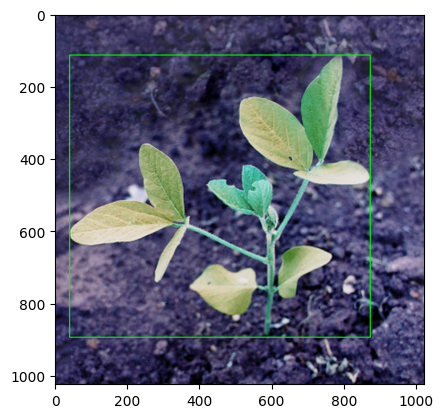

In [15]:
# Drawing a rectangle on the augmented image using bounding box coordinates
cv2.rectangle(
    augmented['image'],  # The image to draw the rectangle on (augmented image)
    tuple(np.multiply(augmented['bboxes'][0][:2], [width, height]).astype(int)),  # Top-left corner coordinates (scaled to original image size)
    tuple(np.multiply(augmented['bboxes'][0][2:], [width, height]).astype(int)),  # Bottom-right corner coordinates (scaled to original image size)
    (0, 255, 0),  # Color of the rectangle (green in BGR format)
    2)  # Thickness of the rectangle's border (2 pixels)

# Displaying the augmented image with the bounding box using matplotlib
plt.imshow(augmented['image'])  # This will show the image with the drawn rectangle in the Jupyter notebook

# Build Augmentation Pipeline

## Create Augmented Data

In [55]:
# Define the augmentation pipeline using Albumentations

# Iterate through partitions
for partition in ['Train', 'Test', 'Val']: 
    # Define paths for images, labels, and augmented data
    image_dir = os.path.join('C:\\Users\\wfenn\\ECEN_403\\Datav2', partition, 'Images')
    label_dir = os.path.join('C:\\Users\\wfenn\\ECEN_403\\Datav2', partition, 'Labels')
    aug_image_dir = os.path.join('C:\\Users\\wfenn\\ECEN_403\\Aug_Datav6', partition, 'Images')
    aug_label_dir = os.path.join('C:\\Users\\wfenn\\ECEN_403\\Aug_Datav6', partition, 'Labels')

    # Ensure output directories exist
    os.makedirs(aug_image_dir, exist_ok=True)
    os.makedirs(aug_label_dir, exist_ok=True)

    # Process each image in the current partition
    for image in os.listdir(image_dir):
        img = cv2.imread(os.path.join(image_dir, image))

        # Get the image dimensions
        height, width, _ = img.shape

        # Initialize empty list for bounding boxes and class labels
        bboxes = []
        class_labels = []
        
        # Define path to the corresponding label file
        label_path = os.path.join(label_dir, f'{image.split(".")[0]}.json')

        # Read labels if the label file exists
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label_data = json.load(f)

            # Iterate through all shapes in the label file (multiple bboxes)
            for shape in label_data['shapes']:
                # Normalize bounding box coordinates based on image dimensions
                coords = [
                    shape['points'][0][0] / width,  # x_min
                    shape['points'][0][1] / height,  # y_min
                    shape['points'][1][0] / width,  # x_max
                    shape['points'][1][1] / height   # y_max
                ]
                bboxes.append(coords)

                # Handle missing 'class' key
                if 'class' in shape:
                    class_labels.append(shape['class'])
                else:
                    # Assign labels based on filename if 'class' is missing
                    if 'soybean' in image.lower():
                        class_labels.append(0)  # Assign 0 for crop
                    elif 'weed' in image.lower() or 'rrpw' in image.lower():
                        class_labels.append(1)  # Assign 1 for weed

        try:
            # Set the number of augmentations based on class label
            if 0 in class_labels:  #crop
                augmentations_count = 22
            elif 1 in class_labels:  #weed
                augmentations_count = 10
            else:
                augmentations_count = 0  # No augmentation if class not recognized

            # Perform augmentation
            for x in range(augmentations_count):
                augmented = augmentor(image=img, bboxes=bboxes, class_labels=class_labels)

                # Save augmented image
                augmented_image_path = os.path.join(aug_image_dir, f'{image.split(".")[0]}.{x}.jpg')
                cv2.imwrite(augmented_image_path, augmented['image'])

                # Prepare and save the augmented bounding box annotations
                augmented_annotations = []
                for aug_bbox, aug_class in zip(augmented['bboxes'], augmented['class_labels']):
                    annotation = {
                        "image": f'{image.split(".")[0]}.{x}.jpg', # Augmented image filename
                        "class": aug_class, # Class label
                        "bbox": aug_bbox  # Coordinates in albumentations format
                    }
                    augmented_annotations.append(annotation)

                # Save annotations to JSON file
                augmented_label_path = os.path.join(aug_label_dir, f'{image.split(".")[0]}.{x}.json')
                with open(augmented_label_path, 'w') as f:
                    json.dump(augmented_annotations, f, indent=4)

        except Exception as e: # Handle errors during processing and display the filename and error
            print(f"Error processing {image}: {e}")


Error processing baby_soybean_bmp.bmp: x_max is less than or equal to x_min for bbox [0.7330729166666667, 0.2048611111111111, 0.5143229166666667, 0.5555555555555556, 0].
Error processing baby_soybean_jpg (29).jpg: x_max is less than or equal to x_min for bbox [0.7183159722222222, 0.9259259259259259, 0.32248263888888895, 0.028935185185185185, 0].
Error processing pigweed_jpg (5).jpg: x_max is less than or equal to x_min for bbox [0.9970668342761366, 0.9940414208029619, 0.006075843285145574, 0.00595857919703804, 1].
Error processing pigweed_jpg (8).jpg: x_max is less than or equal to x_min for bbox [0.994179661761476, 0.9956572090330053, 0.000751828887124291, 0.07730167921250725, 1].
Error processing redroot_pigweed_jpg (52).jpg: y_max is less than or equal to y_min for bbox [0.0038713727678571785, 0.7232142857142857, 0.22011021205357142, 0.12448846726190481, 1].
Error processing rrpw (039).JPG: y_max is less than or equal to y_min for bbox [0.005518353174603178, 0.12913876488095238, 0.2

In [56]:
def augment_background_images():
    # Iterate through partitions
    for partition in ['Train', 'Test', 'Val']: 
        # Define paths for images, labels, and augmented data
        image_dir = os.path.join('C:\\Users\\wfenn\\ECEN_403\\Background', partition, 'Images')
        aug_image_dir = os.path.join('C:\\Users\\wfenn\\ECEN_403\\Aug_Datav6', partition, 'Images')
        aug_label_dir = os.path.join('C:\\Users\\wfenn\\ECEN_403\\Aug_Datav6', partition, 'Labels')

        # Set the augmentation count based on the partition
        augmentation_count = 54 if partition == 'Train' else 50

        # Ensure output directories exist
        os.makedirs(aug_image_dir, exist_ok=True)
        os.makedirs(aug_label_dir, exist_ok=True)

        for image in os.listdir(image_dir):
            img = cv2.imread(os.path.join(image_dir, image))

            # Perform augmentation the specified number of times
            for x in range(augmentation_count):
                augmented = augmentor(image=img, bboxes=[], class_labels=[])

                # Save augmented image
                augmented_image_path = os.path.join(aug_image_dir, f'{image.split(".")[0]}.{x}.jpg')
                cv2.imwrite(augmented_image_path, augmented['image'])

                # Save augmented labels
                augmented_annotations = [{
                    "image": f'{image.split(".")[0]}.{x}.jpg',
                    "class": 2,  # Class 2 for background
                    "bbox": [0, 0, 0, 0]  # Use [0, 0, 0, 0] for background
                }]

                # Save to JSON file in the Labels folder
                augmented_label_path = os.path.join(aug_label_dir, f'{image.split(".")[0]}.{x}.json')
                with open(augmented_label_path, 'w') as f:
                    json.dump(augmented_annotations, f, indent=4)

# Run the augmentation function
augment_background_images()


## Load Augmented Images to Dataset

In [16]:
# converts each image file path into a resized image tensor of 
# shape (224,224,3) with normalized pixel values between (0,1)
train_images = tf.data.Dataset.list_files('C:\\Users\\wfenn\\ECEN_403\\Aug_Datav6\\Train\\Images\\*.jpg', shuffle=False)
# Load each image file and decode it into a tensor with RGB channels
train_images = train_images.map(load_image)
# Explicitly resize each image tensor to (224, 224)
train_images = train_images.map(lambda x: tf.image.resize(x, (224,224)))
# Normalize pixel values to the range [0, 1] by dividing by 255
train_images = train_images.map(lambda x: x/255)

In [17]:
# converts each image file path into a resized image tensor of 
# shape (224,224,3) with normalized pixel values between (0,1)
test_images = tf.data.Dataset.list_files('C:\\Users\\wfenn\\ECEN_403\\Aug_Datav6\\Test\\Images\\*.jpg', shuffle=False)
# Load each image file and decode it into a tensor with RGB channels
test_images = test_images.map(load_image)
# Explicitly resize each image tensor to (224, 224)
test_images = test_images.map(lambda x: tf.image.resize(x, (224,224)))
# Normalize pixel values to the range [0, 1] by dividing by 255
test_images = test_images.map(lambda x: x/255)

In [18]:
# converts each image file path into a resized image tensor of 
# shape (224,224,3) with normalized pixel values between (0,1)
val_images = tf.data.Dataset.list_files('C:\\Users\\wfenn\\ECEN_403\\Aug_Datav6\\Val\\Images\\*.jpg', shuffle=False)
# Load each image file and decode it into a tensor with RGB channels
val_images = val_images.map(load_image)
# Explicitly resize each image tensor to (224, 224)
val_images = val_images.map(lambda x: tf.image.resize(x, (224,224)))
# Normalize pixel values to the range [0, 1] by dividing by 255
val_images = val_images.map(lambda x: x/255)

# Prepare Labels

## Build Label Loading Function

In [19]:
max_classes = 7 

"""
Max number of annotations from a label in the dataset. 
Padding the rest of labels to meet the maximum number of annotations so that 
the number is consistant rather than dealing with variable annotations across each label.
"""

def load_labels(label_path):
    try:
        # Read the JSON file
        label_data = tf.io.read_file(label_path)
        labels = json.loads(label_data.numpy().decode('utf-8'))  # Decode bytes to string

        # Extract classes and bounding boxes
        classes = [item['class'] for item in labels]
        bboxes = [item['bbox'] for item in labels]
        
        # Pad classes list and convert to tensor
        class_tensor = tf.convert_to_tensor(classes + [255] * (max_classes - len(classes)), dtype=tf.uint8)

        # Pad bounding boxes and convert to tensor
        if len(bboxes) == 0: # Background
            # If there are no bounding boxes, fill with padding
            bbox_tensor = tf.convert_to_tensor([[0, 0, 0, 0]] * max_classes, dtype=tf.float32)
        else:
            # Pad bounding boxes
            bbox_tensor = tf.convert_to_tensor(bboxes + [[0, 0, 0, 0]] * (max_classes - len(bboxes)), dtype=tf.float32)
        
        return class_tensor, bbox_tensor

    # Error handling
    except FileNotFoundError:
        print(f"Error: The file {label_path} was not found.")
        return None, None
    except json.JSONDecodeError:
        print(f"Error: The file {label_path} could not be decoded.")
        return None, None


In [20]:
#Function to test and display annotations
def test_load_labels():
    # Load labels
    classes, bboxes = load_labels('C:\\Users\\wfenn\\ECEN_403\\Aug_Datav6\\Test\\Labels\\baby_soybean_jpeg (3).0.json')

    # Print the results
    print("Class Labels:", classes.numpy())  # Convert tensor to numpy for easy reading
    print("Bounding Boxes: \n", bboxes.numpy())

# Run the test
test_load_labels()

Class Labels: [  0   0   0 255 255 255 255]
Bounding Boxes: 
 [[0.24965242 0.27076966 0.40110236 0.5405205 ]
 [0.50703454 0.3645457  0.6659329  0.6041956 ]
 [0.68331236 0.40969715 0.79586536 0.7199685 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


## Load Labels to Dataset

In [21]:
# Load the label files from the directory as a tf.data.Dataset
train_labels = tf.data.Dataset.list_files('C:\\Users\\wfenn\\ECEN_403\\Aug_Datav6\\Train\\Labels\\*.json', shuffle=False)

# Map over each label file and process them using the `load_labels` function
# Use tf.py_function and set shapes for consistent output
train_labels = train_labels.map(
    lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float32]), # Apply `load_labels` function
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Ensure the output shape of each processed label matches the expected dimensions
train_labels = train_labels.map(lambda class_tensor, bbox_tensor: (
    tf.ensure_shape(class_tensor, [max_classes]), #Shape [7]
    tf.ensure_shape(bbox_tensor, [max_classes, 4]))) #Shape [7,4]

In [22]:
# Load the label files from the directory as a tf.data.Dataset
test_labels = tf.data.Dataset.list_files('C:\\Users\\wfenn\\ECEN_403\\Aug_Datav6\\Test\\Labels\\*.json', shuffle=False)

# Map over each label file and process them using the `load_labels` function
# Use tf.py_function and set shapes for consistent output
test_labels = test_labels.map(
    lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float32]), # Apply `load_labels` function
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Ensure the output shape of each processed label matches the expected dimensions
test_labels = test_labels.map(lambda class_tensor, bbox_tensor: (
    tf.ensure_shape(class_tensor, [max_classes]), #Shape [7]
    tf.ensure_shape(bbox_tensor, [max_classes, 4]))) #Shape [7,4]

In [23]:
# Load the label files from the directory as a tf.data.Dataset
val_labels = tf.data.Dataset.list_files('C:\\Users\\wfenn\\ECEN_403\\Aug_Datav6\\Val\\Labels\\*.json', shuffle=False)

# Map over each label file and process them using the `load_labels` function
# Use tf.py_function to call the custom Python function for each file
val_labels = val_labels.map(
    lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float32]), # Apply `load_labels` function
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Ensure the output shape of each processed label matches the expected dimensions
val_labels = val_labels.map(lambda class_tensor, bbox_tensor: (
    tf.ensure_shape(class_tensor, [max_classes]), #Shape [7]
    tf.ensure_shape(bbox_tensor, [max_classes, 4]))) #Shape [7,4]

In [24]:
# Function to print a small batch from the dataset
def print_dataset_example(dataset, num_examples):
    # Iterate over the dataset and print the specified number of examples
    for classes, bboxes in dataset.take(num_examples):
        print("Classes:", classes.numpy())
        print("Bounding Boxes:", bboxes.numpy())

# Print one example from the `test_labels` dataset
print_dataset_example(test_labels, num_examples=1)


Classes: [  0 255 255 255 255 255 255]
Bounding Boxes: [[0.24435765 0.04166667 0.77994794 0.6898148 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


In [25]:
# Convert the train_labels dataset to a NumPy iterator and fetch the next example
train_labels.as_numpy_iterator().next()

(array([  0,   0,   0,   0,   0, 255, 255], dtype=uint8),
 array([[0.81283104, 0.60072243, 0.9431773 , 0.88436604],
        [0.35061905, 0.2487728 , 0.5542075 , 0.79985183],
        [0.6117254 , 0.25687692, 0.84800386, 0.85773826],
        [0.20082429, 0.1248958 , 0.34730867, 0.7558581 ],
        [0.07668498, 0.27771604, 0.20165189, 0.747754  ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]], dtype=float32))

# Combine Labels & Images

In [26]:
#Printing length of train, test, and val images and labels
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5872, 5872, 1228, 1228, 1218, 1218)

In [27]:
# Combine the train_images and train_labels datasets into a single dataset
train = tf.data.Dataset.zip((train_images, train_labels))

# Shuffle the dataset with a buffer size of 6000
# Batch the dataset into batches of size 32
# Prefetch the data in the background while the model is training 
train = train.shuffle(buffer_size=6000)
train = train.batch(32)
train = train.prefetch(4)

In [28]:
# Combine the test_images and test_labels datasets into a single dataset
test = tf.data.Dataset.zip((test_images, test_labels))

# Batch the dataset into batches of size 32 
# Prefetch the data in the background while the model is being evaluated 
test = test.batch(32)
test = test.prefetch(4)

In [29]:
# Combine the val_images and val_labels datasets into a single dataset
val = tf.data.Dataset.zip((val_images, val_labels))

# Batch the dataset into batches of size 32
# Prefetch the data in the background while the model is being validated 
val = val.batch(32)
val = val.prefetch(4)

## View Images &  Labels

In [30]:
# Create an iterator for the training dataset
data_samples = train.as_numpy_iterator()

In [31]:
#Fetching the next batch
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


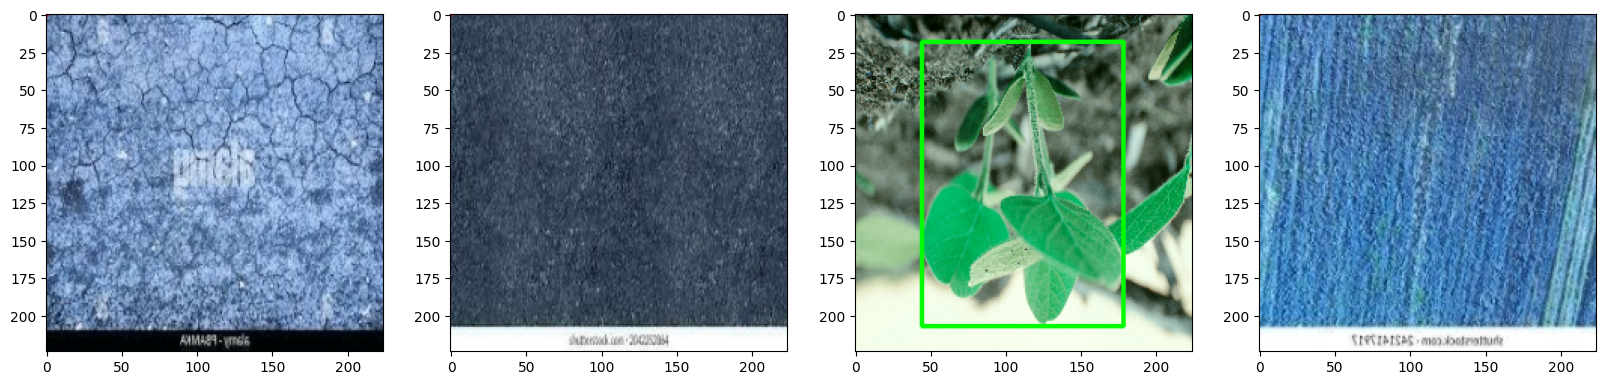

In [32]:
images = res[0]  # Image batch
classes = res[1][0]  # Padded classes
bboxes = res[1][1]  # Padded bounding boxes

# Set up the figure
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))

for ax, img, bbox, cls in zip(axes, images, bboxes, classes):
    # Convert image to BGR format (OpenCV uses BGR)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Draw bounding boxes
    for box, label in zip(bbox, cls):
        if label == 255:  # Skip padded boxes
            continue

        # Rescale, color, & draw bboxes (green for class 0 (crop), red for class 1 (weed))
        x1, y1, x2, y2 = (box * [img.shape[1], img.shape[0], img.shape[1], img.shape[0]]).astype(int)  
        color = (0, 255, 0) if label == 0 else (255, 0, 0) 
        cv2.rectangle(img_bgr, (x1, y1), (x2, y2), color, 2)
    
    # Display the image with bounding boxes on the subplot
    ax.imshow(img_bgr)
    ax.axis('on')
    
# Display the plot with all images and bounding boxes
plt.show()


# Build Deep Learning Model

In [33]:
from tensorflow.keras.models import Model, Sequential  # Import Model and Sequential classes for creating models
from tensorflow.keras import layers, models  # Import layers and models for building and defining neural network structures
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, GlobalMaxPooling2D, Flatten, AveragePooling2D, BatchNormalization, Reshape, Lambda, Activation  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # Import callbacks for model training (e.g., stop early, save model, reduce learning rate)
from tensorflow.keras.regularizers import l1_l2, l2  # Import regularizers to prevent overfitting by adding penalties on model parameters
from tensorflow.keras.applications import VGG16  # Import the pre-trained VGG16 model (used for transfer learning)
from tensorflow.keras.metrics import CategoricalAccuracy  # Import accuracy metric for multi-class classification tasks
from tensorflow.keras.callbacks import Callback  # Import Callback class for creating custom callbacks during training

In [34]:
#Importing VGG16 without the fully connected layer as model backbone
vgg = VGG16(include_top=False)

In [24]:
#Shows vgg architecture
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## Build Instance of Model

In [26]:
# #OG, works
# def build_model(num_boxes=7, num_classes=2): 
#     input_layer = Input(shape=(224, 224, 3))
    
#     # Feature Extraction using VGG16
#     vgg_base = VGG16(include_top=False)(input_layer)
    
#     # Global Feature Pooling
#     f1 = GlobalMaxPooling2D()(vgg_base)
    
#     # Classification Head
#     class_head = Dense(2048, activation='relu')(f1)
#     class_head = BatchNormalization()(class_head)
#     class_head = Dropout(0.5)(class_head)
#     class_head = Dense(num_boxes * num_classes, activation='linear')(class_head)  # Changed to 'linear'
#     class_head = Reshape((num_boxes, num_classes))(class_head)
#     class_head = Lambda(lambda x: tf.nn.softmax(x, axis=-1), name='classification_output')(class_head)  # Apply softmax per box
    
#     # Localization Head
#     regress_head = Dense(2048, activation='relu')(f1)
#     regress_head = BatchNormalization()(regress_head)
#     regress_head = Dropout(0.5)(regress_head)
#     regress_head = Dense(num_boxes * 4, activation='sigmoid')(regress_head)
#     regress_head = Reshape((num_boxes, 4), name='localization_output')(regress_head)
    
#     # Define the Model with Dual Outputs
#     tracker = Model(inputs=input_layer, outputs=[class_head, regress_head])
#     return tracker


In [27]:
#3 class revision
# def build_model(num_boxes=7, num_classes=3): 
#     input_layer = Input(shape=(224, 224, 3))
    
#     # Feature Extraction using VGG16
#     vgg_base = VGG16(include_top=False, input_tensor=input_layer)(input_layer)
    
#     # Global Feature Pooling
#     f1 = GlobalMaxPooling2D()(vgg_base)
    
#     # Classification Head
#     class_head = Dense(2048, activation='relu')(f1)
#     class_head = BatchNormalization()(class_head)
#     class_head = Dropout(0.5)(class_head)
#     class_head = Dense(num_boxes * num_classes, activation='linear')(class_head)  # Use 'linear' before softmax
#     class_head = Reshape((num_boxes, num_classes))(class_head)
#     class_head = Lambda(lambda x: tf.nn.softmax(x, axis=-1), name='classification_output')(class_head)  # Softmax activation
    
#     # Localization Head
#     regress_head = Dense(2048, activation='relu')(f1)
#     regress_head = BatchNormalization()(regress_head)
#     regress_head = Dropout(0.5)(regress_head)
#     regress_head = Dense(num_boxes * 4, activation='sigmoid')(regress_head)
#     regress_head = Reshape((num_boxes, 4), name='localization_output')(regress_head)
    
#     # Define the Model with Dual Outputs
#     tracker = Model(inputs=input_layer, outputs=[class_head, regress_head])
#     return tracker


In [314]:
def build_model(num_boxes=7, num_classes=3):
    input_layer = Input(shape=(224, 224, 3))

    # Feature Extraction using VGG16 with pre-trained weights
    vgg_base = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)
    vgg_base.trainable = False  # Freeze VGG16 layers

    for layer in vgg_base.layers[-6:]:  # Fine-tune only last 2 layers
        layer.trainable = True
    
    vgg_output = vgg_base.output
    f1 = GlobalMaxPooling2D()(vgg_output)
    
    # Classification Head with reduced units and lower dropout
    class_head = Dense(512, activation='relu', kernel_regularizer=l2(0.015))(f1)
    class_head = BatchNormalization()(class_head)
    class_head = Dropout(0.4)(class_head)  # Lower dropout rate
    class_head = Dense(num_boxes * num_classes, activation='linear')(class_head)
    class_head = Reshape((num_boxes, num_classes))(class_head)
    class_head = Lambda(lambda x: tf.nn.softmax(x, axis=-1), name='classification_output')(class_head)
    
    # Localization Head with additional regularization
    regress_head = Dense(512, activation='relu', kernel_regularizer=l2(0.015))(f1)
    regress_head = BatchNormalization()(regress_head)
    regress_head = Dropout(0.2)(regress_head)
    regress_head = Dense(num_boxes * 4, activation='sigmoid')(regress_head)
    regress_head = Reshape((num_boxes, 4), name='localization_output')(regress_head)
    
    # Define the Model with Dual Outputs
    tracker = Model(inputs=input_layer, outputs=[class_head, regress_head])
    return tracker


In [35]:
# WIZARDv15 Model 
def build_model(num_boxes=7, num_classes=3): 
    input_layer = Input(shape=(224, 224, 3))  # Define the input layer with shape 224x224x3 (RGB image)

    # Feature Extraction using VGG16 with pre-trained weights
    vgg_base = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)  # Use VGG16 as a base model for feature extraction, without the fully connected layers
    vgg_base.trainable = False  # Freeze the VGG16 layers to prevent updates during training
    
    vgg_output = vgg_base.output  # Capture the output of VGG16 feature extractor

    # Optionally unfreeze last few layers for fine-tuning
    for layer in vgg_base.layers[-4:]:  # Select the last 4 layers of VGG16 to be trainable
        layer.trainable = True  # Enable training on the selected layers for fine-tuning
    
    # Global Feature Pooling
    f1 = GlobalMaxPooling2D()(vgg_output)  # Apply global max pooling to reduce the spatial dimensions to a single vector
    
    # Classification Head
    class_head = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=0.00095, l2=0.0095))(f1)  # Dense layer with L1/L2 regularization for class prediction
    class_head = BatchNormalization()(class_head)  # Normalize the activations to improve training stability
    class_head = Dropout(0.5)(class_head)  # Dropout layer to prevent overfitting in the classification head
    class_head = Dense(num_boxes * num_classes, activation='linear')(class_head)  # Dense layer to predict class scores for each bounding box
    class_head = Reshape((num_boxes, num_classes))(class_head)  # Reshape to (num_boxes, num_classes) for each bounding box
    class_head = Lambda(lambda x: tf.nn.softmax(x, axis=-1), name='classification_output')(class_head)  # Apply softmax activation to get probabilities for each class
    
    # Localization Head
    regress_head = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.001))(f1)  # Dense layer with L1/L2 regularization for bounding box coordinates
    regress_head = BatchNormalization()(regress_head)  # Normalize the activations in the localization head
    regress_head = Dropout(0.2)(regress_head)  # Dropout layer to reduce overfitting in the localization head
    regress_head = Dense(num_boxes * 4, activation='sigmoid')(regress_head)  # Dense layer for bounding box coordinates (x, y, w, h), scaled between 0 and 1
    regress_head = Reshape((num_boxes, 4), name='localization_output')(regress_head)  # Reshape to (num_boxes, 4) for bounding box output
    
    # Define the Model with Dual Outputs
    tracker = Model(inputs=input_layer, outputs=[class_head, regress_head])  # Create the model with classification and localization heads as outputs
    return tracker  # Return the complete model


## Test Neural Network

In [36]:
# Instantiate the model
tracker = build_model(num_boxes=7, num_classes=3)

In [264]:
#Shows WIZARD model architeture
tracker.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [37]:
#Images - X, Labels - y
#Gets next batch
X, y = train.as_numpy_iterator().next()

In [38]:
#Shows shape of Images
X.shape

(32, 224, 224, 3)

In [39]:
y[0]
# Batch class array

array([[  1,   1,   1, 255, 255, 255, 255],
       [  1, 255, 255, 255, 255, 255, 255],
       [  1, 255, 255, 255, 255, 255, 255],
       [  2, 255, 255, 255, 255, 255, 255],
       [  2, 255, 255, 255, 255, 255, 255],
       [  2, 255, 255, 255, 255, 255, 255],
       [  1, 255, 255, 255, 255, 255, 255],
       [  1, 255, 255, 255, 255, 255, 255],
       [  2, 255, 255, 255, 255, 255, 255],
       [  0,   0,   0, 255, 255, 255, 255],
       [  1,   1, 255, 255, 255, 255, 255],
       [  1, 255, 255, 255, 255, 255, 255],
       [  2, 255, 255, 255, 255, 255, 255],
       [  2, 255, 255, 255, 255, 255, 255],
       [  2, 255, 255, 255, 255, 255, 255],
       [  0,   0, 255, 255, 255, 255, 255],
       [  0,   0, 255, 255, 255, 255, 255],
       [  0, 255, 255, 255, 255, 255, 255],
       [  0,   0, 255, 255, 255, 255, 255],
       [  0,   0, 255, 255, 255, 255, 255],
       [  2, 255, 255, 255, 255, 255, 255],
       [  0, 255, 255, 255, 255, 255, 255],
       [  0, 255, 255, 255, 255,

In [40]:
y[1]
# Batch bounding box array

array([[[7.71950245e-01, 5.55944085e-01, 8.90054405e-01, 6.39860153e-01],
        [2.56021768e-01, 1.85314685e-01, 7.64180243e-01, 5.54778576e-01],
        [2.01631695e-01, 7.64568746e-01, 9.97280478e-01, 9.97668982e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 4.78438428e-03, 7.19907403e-01, 9.92901504e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e

In [41]:
# Prediction class label and bbox coordinates
classes, coords = tracker.predict(X)

1/1 [==============================] - 19s 19s/step


In [42]:
classes, coords
#classes - probability of crop, probability of weed, probability of background
#coords - predicted bbox coordinates

(array([[[0.07840706, 0.23507473, 0.6865182 ],
         [0.61526144, 0.1475915 , 0.2371471 ],
         [0.5062435 , 0.17444962, 0.31930682],
         [0.0634059 , 0.24521364, 0.6913805 ],
         [0.7239562 , 0.1693982 , 0.10664554],
         [0.11931197, 0.5424248 , 0.33826324],
         [0.27317   , 0.10480858, 0.6220214 ]],
 
        [[0.11713962, 0.42032427, 0.46253607],
         [0.42297485, 0.23048761, 0.3465375 ],
         [0.52791053, 0.23024574, 0.24184375],
         [0.09043374, 0.32027426, 0.589292  ],
         [0.91411835, 0.06293149, 0.02295011],
         [0.13721837, 0.3945892 , 0.4681924 ],
         [0.22855744, 0.20669442, 0.56474817]],
 
        [[0.03275109, 0.13874547, 0.82850343],
         [0.5392337 , 0.14947447, 0.31129184],
         [0.5851036 , 0.22551617, 0.18938021],
         [0.04281784, 0.12760136, 0.8295808 ],
         [0.77938104, 0.13843535, 0.08218361],
         [0.20542008, 0.42485744, 0.3697225 ],
         [0.1869837 , 0.02886851, 0.78414774]],
 
    

# Determine Losses & Optimizers

In [43]:
# ADAM (Adaptive Moment Estimation) optimizer algorithm
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [44]:
def localization_loss(y_true, yhat, delta=1.0):
    """
    Computes the Huber loss bewteen predicted and true bboxes
    while ignoring padded entries that don't represent actual bboxes.

    Args:
        y_true: Tensor of true values (ground truth), shape (batch_size, num_boxes, num_classes or 4).
        yhat: Tensor of predicted values, shape (batch_size, num_boxes, num_classes or 4).
        delta: Threshold for switching between L2 and L1 loss.

    Returns:
        Scalar tensor representing the average Huber loss over the batch.
    """
    # Create a mask for valid boxes (non-padded)
    mask = tf.reduce_any(tf.abs(y_true) > 1e-6, axis=-1)  # Adjust based on your padding representation
    mask = tf.cast(mask, dtype=tf.float32)  # Shape: (batch_size, num_boxes)

    # Calculate the absolute differences
    diff = y_true - yhat  # Shape: (batch_size, num_boxes, num_classes or 4)
    abs_diff = tf.abs(diff)  # Shape: (batch_size, num_boxes, num_classes or 4)

    # Calculate Huber loss based on the absolute differences
    quadratic_loss = 0.5 * tf.square(diff)  # Shape: (batch_size, num_boxes, num_classes or 4)
    linear_loss = delta * (abs_diff - 0.5 * delta)  # Shape: (batch_size, num_boxes, num_classes or 4)

    # Use tf.where to select the appropriate loss based on the delta condition
    loss_per_box = tf.where(abs_diff <= delta, quadratic_loss, linear_loss)  # Shape: (batch_size, num_boxes, num_classes or 4)

    # Sum the losses for each bounding box (sum across the last axis)
    loss_per_box_sum = tf.reduce_sum(loss_per_box, axis=-1)  # Shape: (batch_size, num_boxes)

    # Apply the mask to ignore padded boxes
    masked_loss = loss_per_box_sum * mask # Shape: (batch_size, num_boxes)

    # Compute the total loss by summing over all boxes and normalizing by the number of valid boxes
    total_loss = tf.reduce_sum(masked_loss) / (tf.reduce_sum(mask) + 1e-8)  # Scalar

    return total_loss


In [45]:
# CategoricalCrossentropy: used for multi-class classification tasks
# from_logits=False: outputs are probabilities (from softmax activation)

classloss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
regressloss = localization_loss

# Train Neural Network

In [46]:
def prepare_labels(y_classes, num_classes=3):
    """
    Converts class labels to one-hot encoding and sets padded boxes to [0, 0, 1] (Background).

    Args:
        y_classes: Tensor of shape (batch_size, num_boxes), values {0, 1, 2, 255}
        num_classes: Number of classes (including Background)

    Returns:
        Tensor of shape (batch_size, num_boxes, num_classes)
    """
    # Convert to float for manipulation
    y_classes = tf.cast(y_classes, tf.float32)
    
    # Set padded boxes to Background class (2)
    y_classes = tf.where(tf.equal(y_classes, 255), 
                         tf.ones_like(y_classes) * 2,  # Background class index
                         y_classes)
    
    # Check for invalid class labels using tf.assert
    valid_classes = tf.logical_and(tf.greater_equal(y_classes, 0), tf.less(y_classes, num_classes))
    # Use tf.debugging.assert for error checking in TensorFlow's graph mode
    tf.debugging.assert_equal(tf.reduce_all(valid_classes), True, 
                              message="Input contains invalid class labels. Must be in range [0, {}]".format(num_classes - 1))
        
    # Cast to int for one-hot encoding
    y_classes = tf.cast(y_classes, tf.int32)
    
    # One-hot encode the class labels
    y_classes = tf.one_hot(y_classes, depth=num_classes)  # Shape: (batch_size, num_boxes, num_classes)
    
    return y_classes


In [47]:
class Tracker(Model):
    def __init__(self, tracker, **kwargs): # Initializing model "tracker"
        super().__init__(**kwargs)
        self.model = tracker # Store the model
        self.categorical_accuracy = CategoricalAccuracy(name='accuracy') # Metric for accuracy

    # Compiling model with instance variables used during training and evaluation
    def compile(self, opt, classloss, localization_loss, **kwargs): 
        super().compile(**kwargs)
        self.closs = classloss # Store the classification loss
        self.lloss = localization_loss # Store the localization loss
        self.opt = opt # Store the ADAM optimizer

    def train_step(self, batch, **kwargs): 
        X, y = batch  # X = image, y[0] = classes, y[1] = bboxes
        
        # Track gradients with tf.GradientTape
        with tf.GradientTape() as tape: 
            classes_pred, coords_pred = self.model(X, training=True) # Forward pass for predictions
            
            # Prepare labels: [1, 0, 0] for Crop, [0, 1, 0] for Weed, [0, 0, 1] for Background
            labels = prepare_labels(y[0], num_classes=3)  # Shape: (batch_size, num_boxes, 3)

            # Calculates class loss, regress loss, and total loss
            class_loss_value = self.closs(labels, classes_pred)
            localization_loss_value = self.lloss(y[1], coords_pred)
            total_loss = localization_loss_value + class_loss_value

        # Compute gradients and apply them using optimizer
        grad = tape.gradient(total_loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
        # Update categorical accuracy metric
        self.categorical_accuracy.update_state(labels, classes_pred)
        
        # Return loss values and metrics
        return {
            "total_loss": total_loss, 
            "class_loss": class_loss_value, 
            "regress_loss": localization_loss_value, 
            "accuracy": self.categorical_accuracy.result()
        }

    def test_step(self, batch, **kwargs): # Predicts class and bboxes
        X, y = batch
        
        # Get predictions for both class and coordinates (bounding boxes)
        classes_pred, coords_pred = self.model(X, training=False)

        # Prepare labels: [1, 0, 0] for Crop, [0, 1, 0] for Weed, [0, 0, 1] for Background
        labels = prepare_labels(y[0], num_classes=3)  # Shape: (batch_size, num_boxes, 3)

        # Calculates class loss, regress loss, and total loss
        class_loss_value = self.closs(labels, classes_pred)
        localization_loss_value = self.lloss(y[1], coords_pred)
        total_loss = localization_loss_value + class_loss_value
        
        # Update categorical accuracy metric
        self.categorical_accuracy.update_state(labels, classes_pred)

        # Return loss values and metrics
        return {
            "total_loss": total_loss, 
            "class_loss": class_loss_value, 
            "regress_loss": localization_loss_value, 
            "accuracy": self.categorical_accuracy.result()
        }

    def call(self, X, **kwargs): 
        """
        Call the underlying model to get predictions for input X.
        Args:
            X: Input data (images).
        Returns:
            Model predictions (class and coordinates).
        """
        return self.model(X, **kwargs)


In [48]:
# Creating instance of Tracker class model
model = Tracker(tracker)

In [49]:
# Compiles the model with the optimizer and loss functions
model.compile(opt, classloss, regressloss)

In [50]:
# Tensorboard toop used for visualizing metrics like loss and accuracy
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [330]:
loss_lr_scheduler = ReduceLROnPlateau(
    monitor='val_total_loss',        # Monitor validation loss
    factor=0.3,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

In [51]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_total_loss',   # Metric to monitor
    patience=8,                 # Number of epochs with no improvement after which training will stop
    restore_best_weights=True   # Restores model weights from the epoch with the best value of the monitored metric
)

In [56]:
# Training the model with training data and validation data for a specified number of epochs
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback, early_stopping])

Epoch 1/20
184/184 [==============================] - 97s 250ms/step - total_loss: 1.2060 - class_loss: 1.1063 - regress_loss: 0.0997 - accuracy: 0.5120 - val_total_loss: 0.8856 - val_class_loss: 0.8163 - val_regress_loss: 0.0692 - val_accuracy: 0.8456
Epoch 2/20
184/184 [==============================] - 77s 191ms/step - total_loss: 0.6824 - class_loss: 0.6207 - regress_loss: 0.0617 - accuracy: 0.7453 - val_total_loss: 1.0269 - val_class_loss: 1.0050 - val_regress_loss: 0.0218 - val_accuracy: 0.9106
Epoch 3/20
184/184 [==============================] - 74s 201ms/step - total_loss: 0.3211 - class_loss: 0.2755 - regress_loss: 0.0456 - accuracy: 0.9250 - val_total_loss: 0.5391 - val_class_loss: 0.4327 - val_regress_loss: 0.1064 - val_accuracy: 0.9348
Epoch 4/20
184/184 [==============================] - 80s 208ms/step - total_loss: 0.1536 - class_loss: 0.1178 - regress_loss: 0.0358 - accuracy: 0.9828 - val_total_loss: 0.4080 - val_class_loss: 0.3539 - val_regress_loss: 0.0541 - val_accur

## Plot for Losses & Accuracy

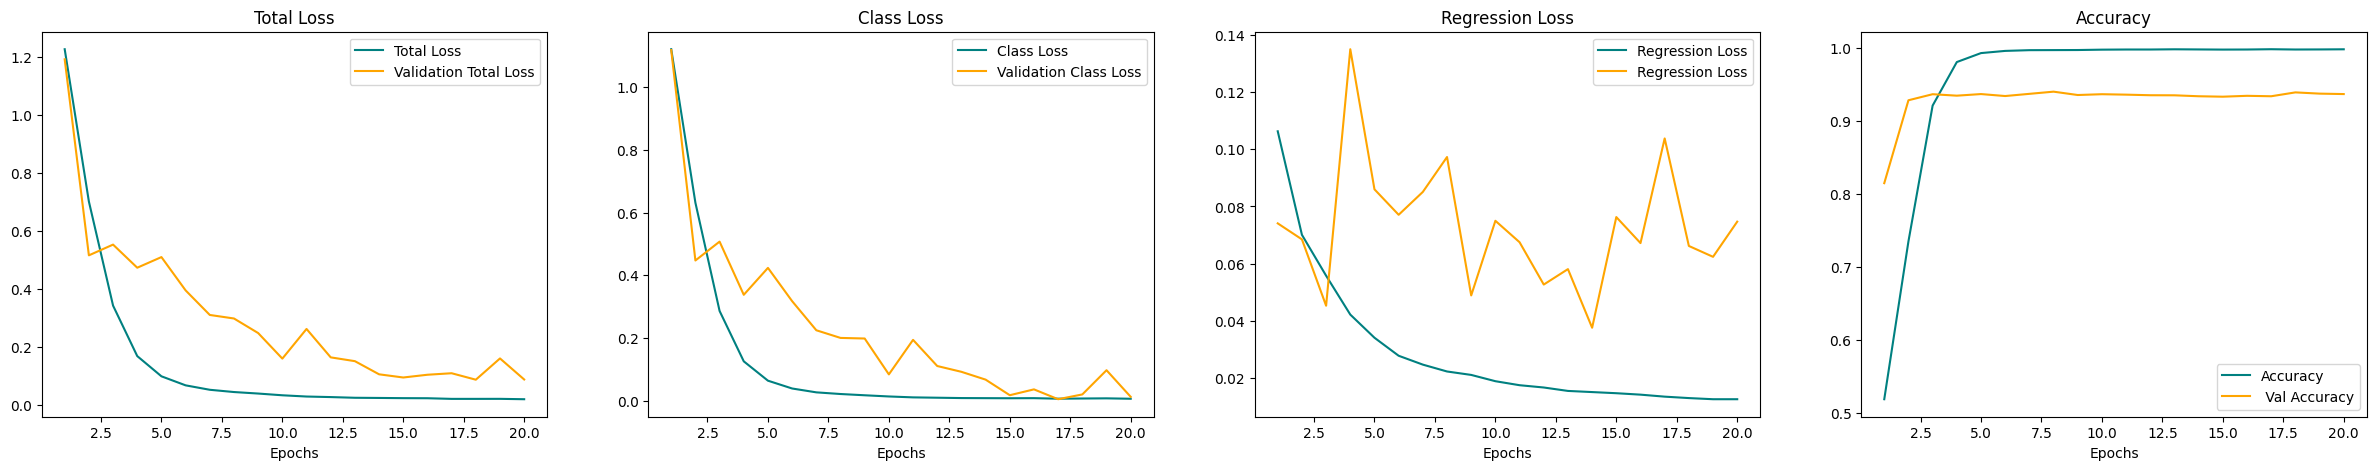

In [93]:
epochs = list(range(1, 21))

# Arrays for each parameter over 20 epochs
total_loss = [1.2274, 0.7017, 0.3423, 0.1680, 0.0982, 0.0670, 0.0517, 0.0439, 0.0387, 0.0327, 0.0284, 0.0265, 0.0241, 0.0235, 0.0228, 0.0225, 0.0203, 0.0203, 0.0204, 0.0191]
class_loss = [1.1211, 0.6316, 0.2865, 0.1258, 0.0641, 0.0392, 0.0269, 0.0216, 0.0176, 0.0138, 0.0109, 0.0098, 0.0087, 0.0084, 0.0081, 0.0084, 0.0067, 0.0073, 0.0078, 0.0065]
regress_loss = [0.1063, 0.0701, 0.0558, 0.0422, 0.0341, 0.0278, 0.0247, 0.0223, 0.0211, 0.0189, 0.0175, 0.0167, 0.0155, 0.0151, 0.0147, 0.0142, 0.0135, 0.0130, 0.0126, 0.0126]
accuracy = [0.5186, 0.7351, 0.9213, 0.9810, 0.9933, 0.9963, 0.9973, 0.9974, 0.9975, 0.9980, 0.9982, 0.9982, 0.9985, 0.9983, 0.9981, 0.9982, 0.9986, 0.9982, 0.9983, 0.9985]
val_total_loss = [1.1926, 0.5158, 0.5529, 0.4731, 0.5098, 0.3948, 0.3100, 0.2978, 0.2475, 0.1593, 0.2617, 0.1636, 0.1505, 0.1051, 0.0941, 0.1036, 0.1088, 0.0865, 0.1599, 0.0872]
val_class_loss = [1.1185, 0.4474, 0.5076, 0.3380, 0.4238, 0.3177, 0.2249, 0.2005, 0.1986, 0.0842, 0.1943, 0.1109, 0.0924, 0.0675, 0.0178, 0.0364, 0.0050, 0.0203, 0.0975, 0.0126]
val_regress_loss = [0.0741, 0.0685, 0.0453, 0.1350, 0.0860, 0.0771, 0.0851, 0.0973, 0.0489, 0.0750, 0.0675, 0.0527, 0.0581, 0.0376, 0.0763, 0.0672, 0.1038, 0.0662, 0.0624, 0.0747]
val_accuracy = [0.8149, 0.9286, 0.9369, 0.9349, 0.9371, 0.9344, 0.9374, 0.9404, 0.9358, 0.9369, 0.9363, 0.9355, 0.9354, 0.9341, 0.9335, 0.9347, 0.9341, 0.9394, 0.9377, 0.9371]

fig, axs = plt.subplots(ncols=4, figsize=(30, 5))

# Total Loss
axs[0].plot(epochs, total_loss, label='Total Loss', color='teal')
axs[0].plot(epochs, val_total_loss, label='Validation Total Loss', color='orange')
axs[0].set_title('Total Loss')
axs[0].set_xlabel('Epochs')
axs[0].legend()

# Class Loss
axs[1].plot(epochs, class_loss, label='Class Loss', color='teal')
axs[1].plot(epochs, val_class_loss, label='Validation Class Loss', color='orange')
axs[1].set_title('Class Loss')
axs[1].set_xlabel('Epochs')
axs[1].legend()

# Regression Loss
axs[2].plot(epochs, regress_loss, label='Regression Loss', color='teal')
axs[2].plot(epochs, val_regress_loss, label='Regression Loss', color='orange')
axs[2].set_title('Regression Loss')
axs[2].set_xlabel('Epochs')
axs[2].legend()

# Accuracy
axs[3].plot(epochs, accuracy, label='Accuracy', color='teal')
axs[3].plot(epochs, val_accuracy, label=' Val Accuracy', color='orange')
axs[3].set_title('Accuracy')
axs[3].set_xlabel('Epochs')
axs[3].legend()

plt.show()


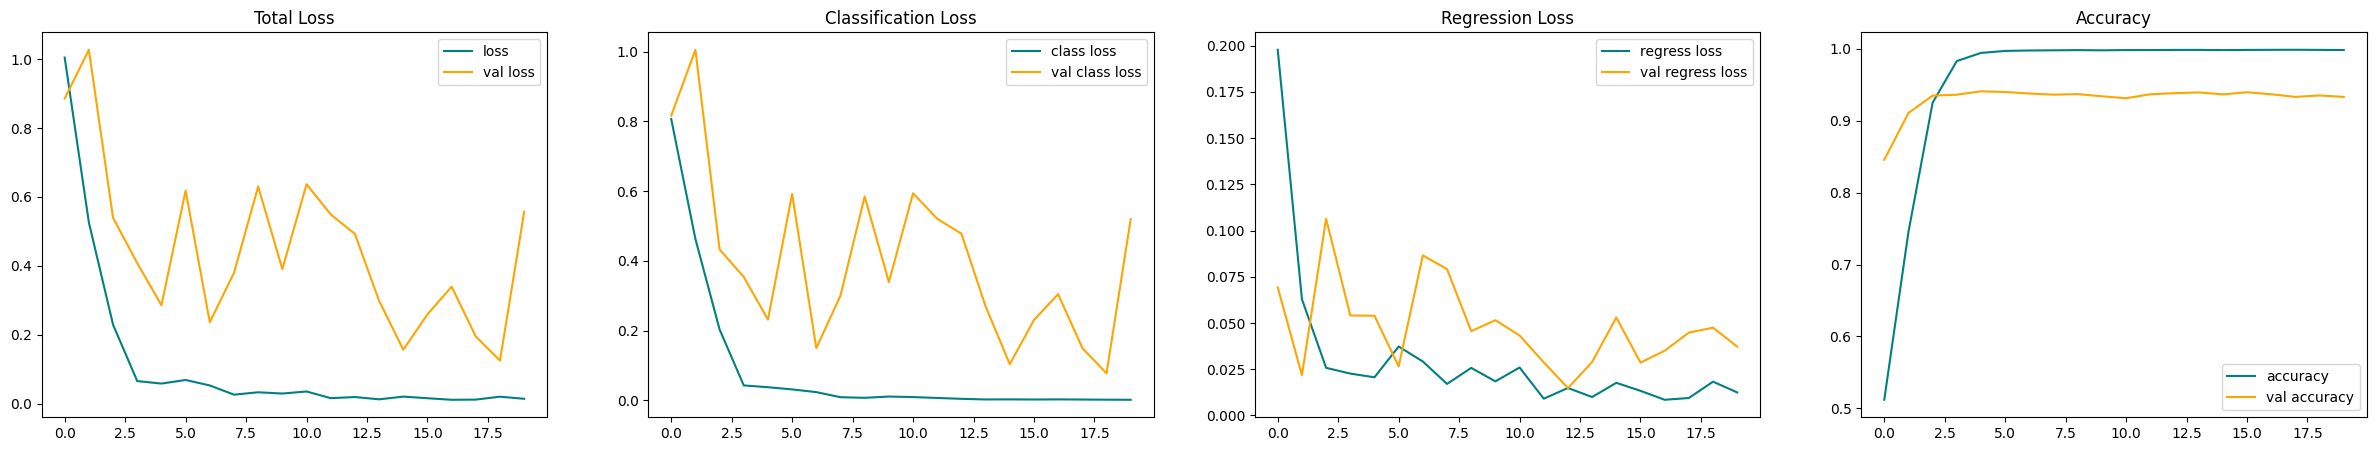

In [57]:
# Create a figure with 4 subplots (columns) for visualizing each metric
fig, ax = plt.subplots(ncols=4, figsize=(30, 5))

# Plot for Total Loss
# Plot training total loss with 'teal' color and label it as 'loss'
ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
# Plot validation total loss with 'orange' color and label it as 'val loss'
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
# Set the title for the first subplot to 'Total Loss'
ax[0].title.set_text('Total Loss')
# Display legend for the first plot
ax[0].legend()

# Plot for Classification Loss
# Plot training classification loss with 'teal' color and label it as 'class loss'
ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
# Plot validation classification loss with 'orange' color and label it as 'val class loss'
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
# Set the title for the second subplot to 'Classification Loss'
ax[1].title.set_text('Classification Loss')
# Display legend for the second plot
ax[1].legend()

# Plot for Regression Loss
# Plot training regression loss with 'teal' color and label it as 'regress loss'
ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
# Plot validation regression loss with 'orange' color and label it as 'val regress loss'
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
# Set the title for the third subplot to 'Regression Loss'
ax[2].title.set_text('Regression Loss')
# Display legend for the third plot
ax[2].legend()

# Plot for Accuracy
# Plot training accuracy with 'teal' color and label it as 'accuracy'
ax[3].plot(hist.history['accuracy'], color='teal', label='accuracy')
# Plot validation accuracy with 'orange' color and label it as 'val accuracy'
ax[3].plot(hist.history['val_accuracy'], color='orange', label='val accuracy')
# Set the title for the fourth subplot to 'Accuracy'
ax[3].title.set_text('Accuracy')
# Display legend for the fourth plot
ax[3].legend()

# Show all the plots in a single figure
plt.show()


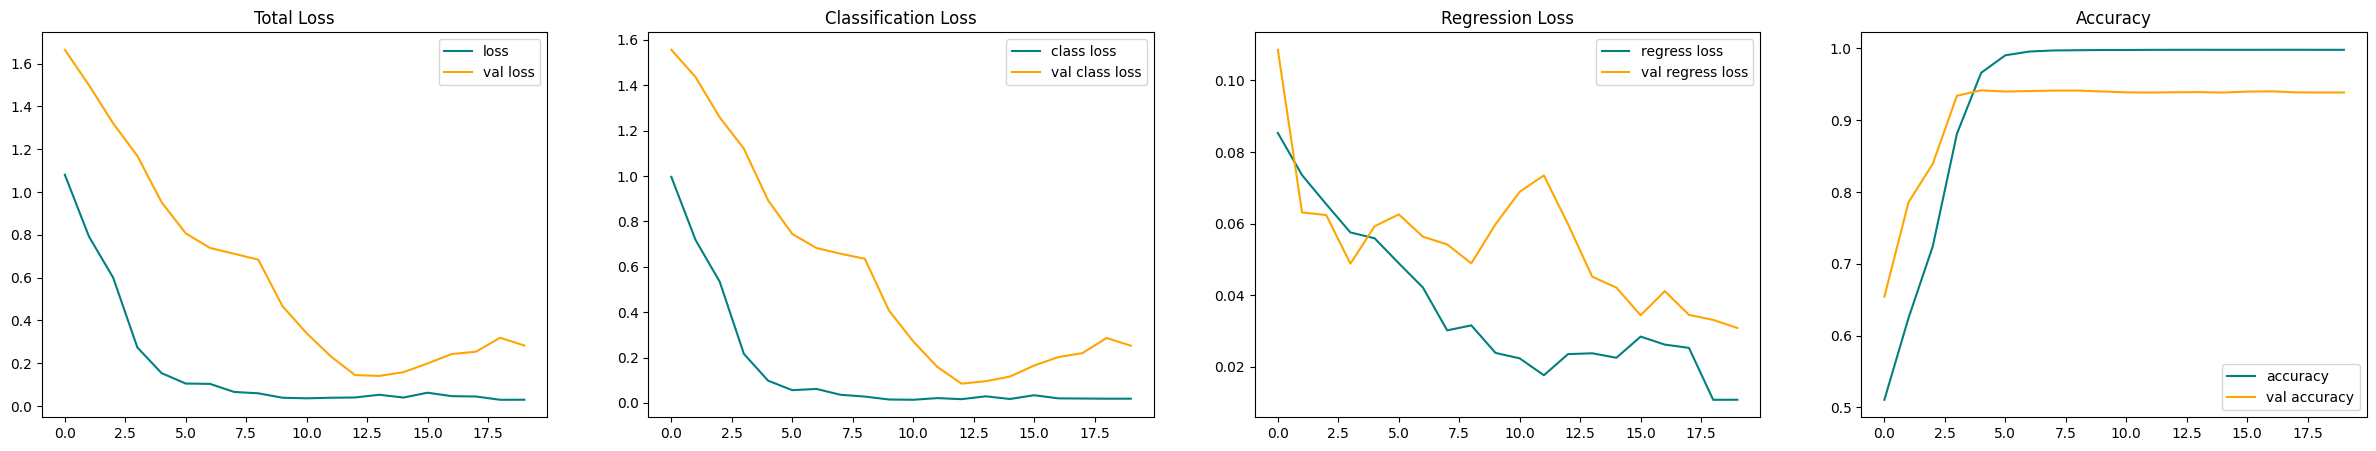

In [168]:
# Define a function to smooth out data points using a moving average
def smooth_curve(points, window_size=3):
    smoothed_points = []  # Initialize a list to store smoothed points
    for i in range(len(points)):
        # Determine the start of the moving window, ensuring we don't go below index 0
        start = max(0, i - window_size + 1)
        # Extract the window of points to average
        window = points[start:i + 1]
        # Calculate the average of the current window and append to smoothed points
        smoothed_points.append(sum(window) / len(window))
    return smoothed_points  # Return the list of smoothed points

# Create a figure with 4 subplots for visualizing each metric
fig, ax = plt.subplots(ncols=4, figsize=(30, 5))

# Plot for Total Loss
# Smooth and plot training total loss with 'teal' color
ax[0].plot(smooth_curve(hist.history['total_loss']), color='teal', label='loss')
# Smooth and plot validation total loss with 'orange' color
ax[0].plot(smooth_curve(hist.history['val_total_loss']), color='orange', label='val loss')
# Set the title for the first subplot to 'Total Loss'
ax[0].title.set_text('Total Loss')
# Display legend for the first plot
ax[0].legend()

# Plot for Classification Loss
# Smooth and plot training classification loss with 'teal' color
ax[1].plot(smooth_curve(hist.history['class_loss']), color='teal', label='class loss')
# Smooth and plot validation classification loss with 'orange' color
ax[1].plot(smooth_curve(hist.history['val_class_loss']), color='orange', label='val class loss')
# Set the title for the second subplot to 'Classification Loss'
ax[1].title.set_text('Classification Loss')
# Display legend for the second plot
ax[1].legend()

# Plot for Regression Loss
# Smooth and plot training regression loss with 'teal' color
ax[2].plot(smooth_curve(hist.history['regress_loss']), color='teal', label='regress loss')
# Smooth and plot validation regression loss with 'orange' color
ax[2].plot(smooth_curve(hist.history['val_regress_loss']), color='orange', label='val regress loss')
# Set the title for the third subplot to 'Regression Loss'
ax[2].title.set_text('Regression Loss')
# Display legend for the third plot
ax[2].legend()

# Plot for Accuracy
# Smooth and plot training accuracy with 'teal' color
ax[3].plot(smooth_curve(hist.history['accuracy']), color='teal', label='accuracy')
# Smooth and plot validation accuracy with 'orange' color
ax[3].plot(smooth_curve(hist.history['val_accuracy']), color='orange', label='val accuracy')
# Set the title for the fourth subplot to 'Accuracy'
ax[3].title.set_text('Accuracy')
# Display legend for the fourth plot
ax[3].legend()

# Show all the plots in a single figure
plt.show()


# Test Set Predictions

In [52]:
def plot_predictions_with_background(yhat, test_sample, iou_threshold=0.5, score_threshold=0.5):
    
    """
    Plots the predictions with Non-Maximum Suppression applied and handles Background class.
    yhat: Tuple of (class_predictions, bbox_predictions)
    test_sample: Tuple of (images, labels)
    iou_threshold: IoU threshold for NMS
    score_threshold: Confidence threshold to filter boxes
    """
    
    class_preds, bbox_preds = yhat  # Unpacks the predictions into class probabilities and bounding box coordinates
    images = test_sample[0]  # Extracts images from the test sample tuple
    num_images = 4  # Set the number of images to display
    fig, ax = plt.subplots(ncols=num_images, figsize=(20, 20))  # Creates subplots to display images
    
    for img_idx in range(num_images):  # Loops through the number of images
        # Copy the current image to add bounding boxes
        sample_image = images[img_idx].copy()  # Copies the image for modification
        class_probs = class_preds[img_idx]  # Extracts the class probabilities for the current image
        bbox_coords = bbox_preds[img_idx]   # Extracts the bounding box coordinates for the current image
        label_classes = test_sample[1][0][img_idx]  # Extracts the labels for the current image

        boxes = []  # List to hold the bounding box coordinates
        scores = []  # List to hold the confidence scores for each box
        classes = []  # List to hold the class labels for each box
        
        for box_idx in range(7):  # Loops through each of the 7 boxes in the prediction
            if label_classes[box_idx] == 255:  # If the class label is 255, it's a padded box (no object)
                # Assign zero probability and coordinates to padded boxes
                class_probs[box_idx] = [0, 0, 1]  # Set class probabilities to background
                bbox_coords[box_idx] = [0, 0, 0, 0]  # Set bounding box coordinates to (0, 0, 0, 0)
                continue  # Skip plotting padded boxes

            # Extract probabilities for each class (Crop, Weed, Background)
            prob_crop, prob_weed, prob_background = class_probs[box_idx]
            
            # Determine the class with the highest probability
            if prob_background > score_threshold:  
                continue  # Skip for background case

            # Handle Crop class (only display confidence score, no bounding box)
            if prob_crop > prob_weed and prob_crop > score_threshold:  
                class_name = "Crop"  # Set the class name to Crop
                confidence = prob_crop  # Set the confidence to the crop probability
                color = (0, 255, 0)  # Set label color to green
                # Display confidence score at bottom-left corner of the image
                bottom_left_corner = (10, sample_image.shape[0] - 10)  # Coordinates for the bottom-left corner
                cv2.putText(sample_image, f'{class_name}: {confidence:.2f}', bottom_left_corner, 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)  # Add text to the image
                continue  # Skip drawing a bounding box for Crop

            # Handle Weed class (display bounding box with score)
            elif prob_weed > prob_crop and prob_weed > score_threshold: 
                class_name = "Weed"  # Set the class name to Weed
                confidence = prob_weed  # Set the confidence to the weed probability
                color = (255, 0, 0)  # Set the bounding box color to red
                
                # Append bounding box coordinates, confidence score, and class to lists for selected boxes
                boxes.append(bbox_coords[box_idx])
                scores.append(confidence)
                classes.append(class_name)
        
        if boxes:  # If there are any boxes to process
            boxes = np.array(boxes)  # Convert bounding boxes to NumPy array
            scores = np.array(scores)  # Convert scores to NumPy array
            classes = np.array(classes)  # Convert classes to NumPy array
            
            # Apply Non-Maximum Suppression (NMS) to reduce overlapping boxes
            selected_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=5, iou_threshold=iou_threshold) 
            selected_boxes = tf.gather(boxes, selected_indices).numpy()  # Get selected bounding boxes
            selected_scores = tf.gather(scores, selected_indices).numpy()  # Get selected scores
            selected_classes = classes[selected_indices.numpy()]  # Get selected classes

            for i in range(len(selected_boxes)):  # Loop through the selected boxes after NMS
                box = selected_boxes[i]  # Get the coordinates of the selected bounding box
                class_name = selected_classes[i]  # Get the class name for the selected box
                score = selected_scores[i]  # Get the confidence score for the selected box
                color = (0, 255, 0) if class_name == "Crop" else (255, 0, 0)  # Set the color to green for Crop or red for Weed
                
                # Scale bounding boxes to the image size (224x224)
                start_point = tuple(np.multiply(box[:2], [224, 224]).astype(int))  # Calculate the top-left corner
                end_point = tuple(np.multiply(box[2:], [224, 224]).astype(int))  # Calculate the bottom-right corner
                
                # Draw the bounding box on the image (only for Weed)
                cv2.rectangle(sample_image, start_point, end_point, color, 2)  # Draw the rectangle on the image
                # Add a label with the class name and confidence score
                cv2.putText(sample_image, f'{class_name}: {score:.2f}', start_point, 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)  # Display the label on the image
        
        ax[img_idx].imshow(sample_image)  # Display the image in the corresponding subplot
        ax[img_idx].axis('on')  # Turn on the axis for the subplot
        
    plt.show()  # Display the plot

In [53]:
# Create an iterator for the test dataset to manually retrieve batches of data
test_data = test.as_numpy_iterator()

In [54]:
# Retrieve the next batch of data from the test iterator
test_sample = test_data.next()

In [55]:
# Unpack the batch into features (X_test) and labels (y_test)
# Use the model to make predictions on the test batch (X_test)
X_test, y_test = test_sample
yhat = tracker.predict(X_test)

1/1 [==============================] - 0s 170ms/step


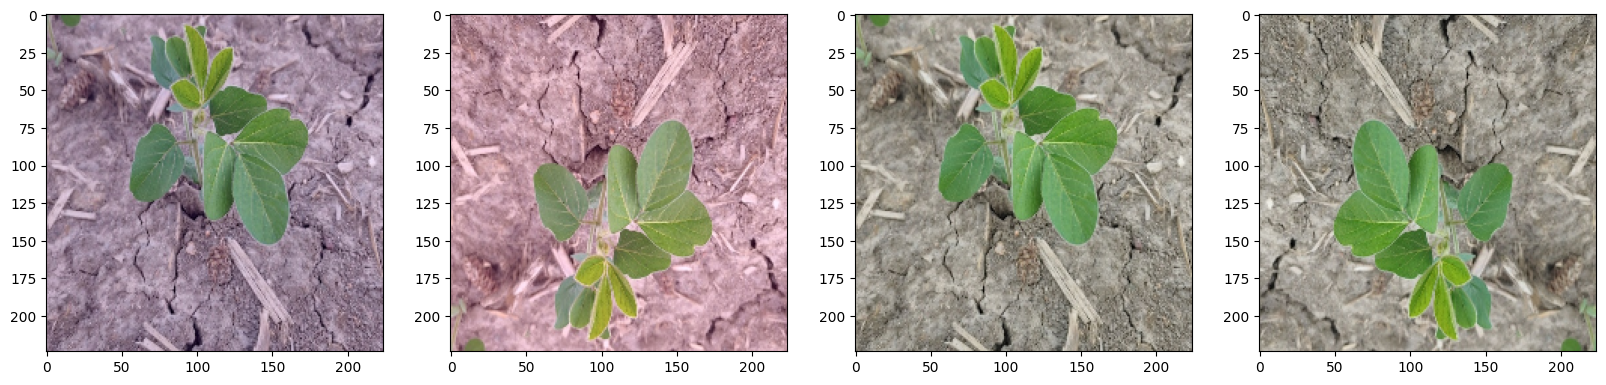

In [56]:
#Test predictions on current model
plot_predictions_with_background(yhat, test_sample, iou_threshold=0.5, score_threshold=0.5)

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


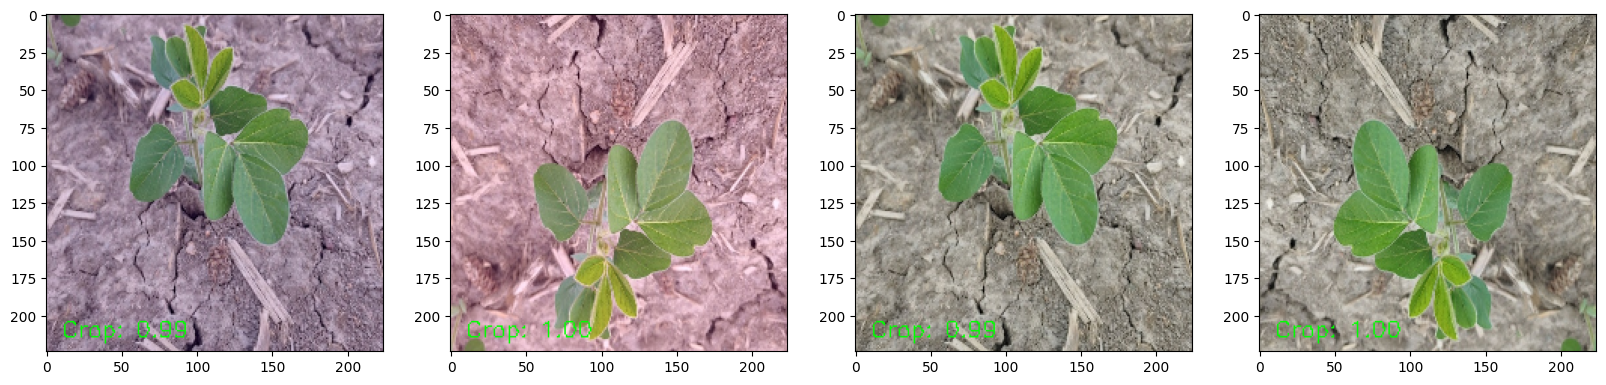

In [59]:
# Predicitions with older model
model_path = 'WIZARDv15.h5'  
tracker = load_model(model_path)

# Get the test data iterator once
test_data = test.as_numpy_iterator()

# Function to manually test a batch
def test_batch(batch_idx=0, iou_threshold=0.5, score_threshold=0.5):
    """
    Manually test a batch from the test dataset and plot the predictions.
    batch_idx: Index of the batch to test (0, 1, 2, etc.)
    """
    # Fetch the batch
    for _ in range(batch_idx):
        test_data.next()  # Skip to the desired batch
    
    # Get the next batch (or the batch at batch_idx)
    test_sample = test_data.next()
    X_test, y_test = test_sample
    
    # Run model prediction
    yhat = tracker.predict(X_test)
    
    # Plot predictions for this batch
    plot_predictions_with_background(yhat, test_sample, iou_threshold, score_threshold)

# To test a specific batch, just call:
test_batch(batch_idx=0)

# 0, 2, 4, 19, 35, 36!, 37 Crop
# 21-23, 27, 31 Weed
# 24, 25!, 30 Multi Weed

In [58]:
#Loads in any saved model
from tensorflow.keras.models import load_model

In [100]:
#Saves the model version
tracker.save('WIZARDv18.h5')

In [101]:
#Loads in the model for use
tracker = load_model('WIZARDv18.h5')

## Real Time Detection Code

In [73]:
# Load the trained model
model_path = 'WIZARDv15.h5'  
tracker = load_model(model_path)  # Load the trained model using Keras' load_model function

# Define colors for bounding boxes
CROP_COLOR = (0, 255, 0)  # Green color for crop (only for text)
WEED_COLOR = (0, 0, 255)  # Red color for weeds

def preprocess_frame(frame, input_size=(224, 224)):
    """Preprocess the frame for model input."""
    frame_resized = cv2.resize(frame, input_size)  # Resize the frame to the input size expected by the model (224x224)
    frame_normalized = frame_resized / 255.0  # Normalize pixel values to the range [0, 1]
    return np.expand_dims(frame_normalized, axis=0)  # Add batch dimension (expand to shape (1, 224, 224, 3))

def draw_bounding_boxes(frame, yhat, iou_threshold=0.5, score_threshold=0.75):
    """Draw bounding boxes on the frame using model predictions."""
    class_preds, bbox_preds = yhat  # Extract class predictions and bounding box predictions from the model's output
    sample_image = frame.copy()  # Create a copy of the frame to draw on

    class_probs = class_preds[0]  # Shape: (7, 3) - Class probabilities for 7 boxes
    bbox_coords = bbox_preds[0]   # Shape: (7, 4) - Bounding box coordinates for 7 boxes

    boxes = []  # List to store valid bounding boxes
    scores = []  # List to store confidence scores for bounding boxes
    classes = []  # List to store class labels for bounding boxes

    # Iterate through each bounding box prediction
    for box_idx in range(7):  # Assuming there are 7 bounding boxes predicted per image
        # Extract the probabilities for each class (Crop, Weed, Background)
        prob_crop, prob_weed, prob_background = class_probs[box_idx]

        # For Crop: do not display bounding box, only show confidence score at bottom left
        if prob_crop > prob_weed and prob_crop > score_threshold:
            class_name = "Crop"  # Label the object as "Crop"
            confidence = prob_crop  # Set confidence score to crop's probability
            color = CROP_COLOR  # Set color to green for crop
            continue  # Skip adding bounding box for Crop, handled separately

        # For Weed: display bounding box with confidence score
        elif prob_weed > prob_crop and prob_weed > score_threshold:
            class_name = "Weed"  # Label the object as "Weed"
            confidence = prob_weed  # Set confidence score to weed's probability
            color = WEED_COLOR  # Set color to red for weed
            boxes.append(bbox_coords[box_idx])  # Add bounding box coordinates to the list
            scores.append(confidence)  # Add confidence score to the list
            classes.append(class_name)  # Add class label to the list

        else:
            continue  # Skip low-confidence or background detections

    if boxes:  # If there are valid boxes to display
        boxes = np.array(boxes)  # Convert list of boxes to a numpy array
        scores = np.array(scores)  # Convert list of scores to a numpy array
        classes = np.array(classes)  # Convert list of classes to a numpy array

        # Apply Non-Maximum Suppression to remove overlapping boxes
        selected_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=5, iou_threshold=iou_threshold)
        selected_boxes = tf.gather(boxes, selected_indices).numpy()  # Get boxes that were selected after NMS
        selected_scores = tf.gather(scores, selected_indices).numpy()  # Get scores for selected boxes
        selected_classes = classes[selected_indices.numpy()]  # Get class labels for selected boxes

        # Draw each box that was kept after NMS
        for i in range(len(selected_boxes)):
            box = selected_boxes[i]  # Get coordinates of the bounding box
            class_name = selected_classes[i]  # Get the class name of the object
            score = selected_scores[i]  # Get confidence score
            color = WEED_COLOR  # Set color to red for weed

            # Scale bounding boxes back to original frame size
            frame_height, frame_width = frame.shape[:2]  # Get the dimensions of the original frame
            start_point = tuple(np.multiply(box[:2], [frame_width, frame_height]).astype(int))  # Top-left corner
            end_point = tuple(np.multiply(box[2:], [frame_width, frame_height]).astype(int))  # Bottom-right corner

            # Draw the bounding box on the frame for Weed
            if class_name == "Weed":  # Only draw box for "Weed" class
                cv2.rectangle(frame, start_point, end_point, color, 2)  # Draw rectangle
                cv2.putText(frame, f'{class_name}: {score:.2f}', start_point,  # Add text showing class and score
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)

    # Display Crop confidence score at the bottom left of the frame (no bounding box)
    for box_idx in range(7):
        prob_crop = class_probs[box_idx][0]  # Get crop class probability
        if prob_crop > score_threshold:  # If crop probability exceeds the threshold
            cv2.putText(frame, f'Crop: {prob_crop:.2f}', (10, frame.shape[0] - 10),  # Display crop score at bottom left
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, CROP_COLOR, 2, cv2.LINE_AA)
            break  # Only display one Crop confidence score (for the first detected crop)

    return frame  # Return the frame with bounding boxes and labels

def real_time_detection(model):
    """Function to run real-time object detection with webcam using the preloaded `tracker` model."""
    cap = cv2.VideoCapture(0)  # Open the webcam (0 is the default camera)

    # Check if the webcam is opened successfully
    if not cap.isOpened():
        print("Error: Could not open webcam.")  # If there's an error, print and return
        return

    # Set up the video writer to save the output
    now = datetime.now().strftime('%Y%m%d_%H%M%S')  # Get current timestamp for file naming
    output_filename = f'C:\\Users\\wfenn\\ECEN_403\\RealTimeObjectDetection\\Real_Time_Tests\\{model_path.split(".")[0]}_{now}.mp4'  # File path for output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Video codec (MP4)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Get the frame width of the video
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Get the frame height of the video
    out = cv2.VideoWriter(output_filename, fourcc, 5.0, (frame_width, frame_height))  # Initialize video writer

    # Loop to continuously capture frames from the webcam
    while True:
        ret, frame = cap.read()  # Capture a frame from the webcam

        if not ret:  # If frame capture fails
            print("Error: Failed to capture image.")  # Print error message and break the loop
            break

        # Un-mirror the frame by flipping it horizontally
        #frame = cv2.flip(frame, 1)
        
        # Preprocess the frame for the model
        preprocessed_frame = preprocess_frame(frame)  # Preprocess the captured frame
        # Get predictions from the model
        yhat = tracker.predict(preprocessed_frame)  # Get model's output
        # Draw the bounding boxes based on the predictions
        output_frame = draw_bounding_boxes(frame, yhat)  # Get the frame with bounding boxes drawn

        # Write the frame to the output file
        out.write(output_frame)  # Save the frame with bounding boxes to the output video file

        # Display the frame with bounding boxes
        cv2.imshow('Real-Time Detection', output_frame)  # Show the frame in a window

        if cv2.waitKey(50) & 0xFF == ord('q'):  # Wait for 'q' key to exit
            break

    cap.release()  # Release the webcam
    out.release()  # Release the video writer
    cv2.destroyAllWindows()  # Close all OpenCV windows

# Start real-time detection
real_time_detection(tracker) 

1/1 [==============================] - 0s 92ms/step


In [ ]:
#FOR BIT TEST RED LED ERROR (mihgt need to install deps)

import RPi.GPIO as GPIO  # Import GPIO library for Raspberry Pi

# Setup for the red LED
RED_LED_PIN = 18  # Choose a GPIO pin (make sure it matches your hardware setup)

# Initialize GPIO settings
GPIO.setmode(GPIO.BCM)  # Set GPIO numbering mode
GPIO.setup(RED_LED_PIN, GPIO.OUT)  # Set pin as output

def real_time_detection(model):
    """Function to run real-time object detection with webcam using the preloaded `tracker` model."""
    cap = cv2.VideoCapture(0)  # Open the webcam (0 is the default camera)

    if not cap.isOpened():
        # If the webcam is not detected, turn on the red LED and print an error message
        GPIO.output(RED_LED_PIN, GPIO.HIGH)  # Turn on red LED
        print("Error: Could not open webcam.")
        return  # Exit the function if no camera is detected
    else:
        GPIO.output(RED_LED_PIN, GPIO.LOW)  # Turn off the red LED if the camera is detected

    while True:
        ret, frame = cap.read()

        if not ret:
            print("Error: Failed to capture image.")
            break

        # Process and display the frame as per your original code

        # Press 'q' to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()  # Release the webcam
    cv2.destroyAllWindows()  # Close all OpenCV windows

# Clean up GPIO on exit
try:
    real_time_detection(tracker)
finally:
    GPIO.output(RED_LED_PIN, GPIO.LOW)  # Ensure LED is off when program ends
    GPIO.cleanup()  # Reset GPIO settings


In [ ]:
#SETTING TIMER TO SEND CHARGING SIGNAL (SINGULAR WEED?)

def real_time_detection(model):
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    # Initialize timing for high-confidence weed detection
    high_conf_weed_detected = False
    detection_start_time = None
    required_detection_duration = 3  # seconds
    confidence_threshold = 0.95

    while True:
        ret, frame = cap.read()

        if not ret:
            print("Error: Failed to capture image.")
            break

        preprocessed_frame = preprocess_frame(frame)
        yhat = tracker.predict(preprocessed_frame)
        output_frame = draw_bounding_boxes(frame, yhat)

        # Check for high-confidence weed detection
        weed_detected = False
        class_preds, _ = yhat
        class_probs = class_preds[0]  # Get the probabilities for this frame

        for box_idx in range(7):
            prob_crop, prob_weed, _ = class_probs[box_idx]
            if prob_weed > confidence_threshold:
                weed_detected = True
                break

        if weed_detected:
            if not high_conf_weed_detected:
                # Start timer if not already started
                detection_start_time = time.time()
                high_conf_weed_detected = True
            elif time.time() - detection_start_time >= required_detection_duration:
                # Weed detected with high confidence for 3 consecutive seconds
                print("Sending signal to MCU")
                # Reset detection timer after sending signal
                high_conf_weed_detected = False
                detection_start_time = None
        else:
            # Reset if no weed detected or below threshold
            high_conf_weed_detected = False
            detection_start_time = None

        cv2.imshow('Real-Time Detection', output_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

real_time_detection(tracker)

In [ ]:
#TIMER FOR BOTH SINGULAR AND MULTIPLE WEEDS WITH PRINT STATEMENT


def preprocess_frame(frame, input_size=(224, 224)):
    frame_resized = cv2.resize(frame, input_size)
    frame_normalized = frame_resized / 255.0
    return np.expand_dims(frame_normalized, axis=0)

def draw_bounding_boxes(frame, yhat, iou_threshold=0.5, score_threshold=0.90):
    class_preds, bbox_preds = yhat
    class_probs = class_preds[0]
    bbox_coords = bbox_preds[0]

    boxes, scores, classes = [], [], []
    for box_idx in range(7):
        prob_crop, prob_weed, _ = class_probs[box_idx]

        if prob_crop > prob_weed and prob_crop > score_threshold:
            class_name, confidence, color = "Crop", prob_crop, (0, 255, 0)
        elif prob_weed > prob_crop and prob_weed > score_threshold:
            class_name, confidence, color = "Weed", prob_weed, (0, 0, 255)
        else:
            continue

        boxes.append(bbox_coords[box_idx])
        scores.append(confidence)
        classes.append(class_name)

    if boxes:
        boxes = np.array(boxes)
        scores = np.array(scores)
        classes = np.array(classes)
        selected_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=5, iou_threshold=iou_threshold)
        selected_boxes = tf.gather(boxes, selected_indices).numpy()
        selected_scores = tf.gather(scores, selected_indices).numpy()
        selected_classes = classes[selected_indices.numpy()]

        for i in range(len(selected_boxes)):
            box = selected_boxes[i]
            class_name = selected_classes[i]
            score = selected_scores[i]
            color = (0, 255, 0) if class_name == "Crop" else (0, 0, 255)

            frame_height, frame_width = frame.shape[:2]
            start_point = tuple(np.multiply(box[:2], [frame_width, frame_height]).astype(int))
            end_point = tuple(np.multiply(box[2:], [frame_width, frame_height]).astype(int))

            cv2.rectangle(frame, start_point, end_point, color, 2)
            cv2.putText(frame, f'{class_name}: {score:.2f}', start_point, 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)

    return frame, selected_boxes, selected_classes, selected_scores

def real_time_detection(model):
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    confidence_threshold = 0.95
    detection_durations = {}
    required_detection_duration = 3

    while True:
        ret, frame = cap.read()

        if not ret:
            print("Error: Failed to capture image.")
            break

        preprocessed_frame = preprocess_frame(frame)
        yhat = tracker.predict(preprocessed_frame)
        output_frame, boxes, classes, scores = draw_bounding_boxes(frame, yhat)

        current_time = time.time()
        for i, (box, class_name, score) in enumerate(zip(boxes, classes, scores)):
            if class_name == "Weed" and score > confidence_threshold:
                box_id = tuple(box)  # Unique identifier for the bounding box

                if box_id not in detection_durations:
                    detection_durations[box_id] = current_time
                elif current_time - detection_durations[box_id] >= required_detection_duration:
                    print("Sending signal to MCU for weed detection")
                    detection_durations[box_id] = current_time + required_detection_duration
            else:
                # Remove box from tracking if not detected or below confidence
                detection_durations.pop(tuple(box), None)

        cv2.imshow('Real-Time Detection', output_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

real_time_detection(tracker)


In [52]:
#TIMER WITH WEED COORDS & PRINT STATEMENT

def preprocess_frame(frame, input_size=(224, 224)):
    """Preprocess the frame for model input."""
    frame_resized = cv2.resize(frame, input_size)
    frame_normalized = frame_resized / 255.0  # Normalize to [0,1] range
    return np.expand_dims(frame_normalized, axis=0)  # Add batch dimension

def draw_bounding_boxes(frame, yhat, iou_threshold=0.5, score_threshold=0.90):
    """Draw bounding boxes on the frame using model predictions."""
    class_preds, bbox_preds = yhat
    sample_image = frame.copy()

    # Extract class probabilities and bounding boxes for the first (and only) image in the batch
    class_probs = class_preds[0]  # Shape: (7, 3)
    bbox_coords = bbox_preds[0]   # Shape: (7, 4)

    boxes = []
    scores = []
    classes = []

    # Dictionary to track time for each bounding box (using coordinates as unique keys)
    for box_idx in range(7):  # Assuming there are 7 bounding boxes predicted per image
        prob_crop, prob_weed, prob_background = class_probs[box_idx]

        # Determine the class with the highest probability and compare to score_threshold
        if prob_crop > prob_weed and prob_crop > score_threshold:
            class_name = "Crop"
            confidence = prob_crop
            color = (0, 255, 0)  # Green for Crop
        
        elif prob_weed > prob_crop and prob_weed > score_threshold:
            class_name = "Weed"
            confidence = prob_weed
            color = (0, 0, 255)  # Red for Weed
       
        else:
            continue    # Skip if confidence is below threshold or it is background
        
        # Store bounding box and class info if it passes the threshold
        boxes.append(bbox_coords[box_idx])
        scores.append(confidence)
        classes.append(class_name)

    if boxes:
        boxes = np.array(boxes)
        scores = np.array(scores)
        classes = np.array(classes)

        selected_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=5, iou_threshold=iou_threshold)
        selected_boxes = tf.gather(boxes, selected_indices).numpy()
        selected_scores = tf.gather(scores, selected_indices).numpy()
        selected_classes = classes[selected_indices.numpy()]

        # Track detection duration for each weed bounding box
        detection_times = {}

        for i in range(len(selected_boxes)):
            box = tuple(selected_boxes[i])  # Convert box coordinates to a hashable tuple for tracking
            class_name = selected_classes[i]
            score = selected_scores[i]
            color = (0, 255, 0) if class_name == "Crop" else (0, 0, 255)  # Green for Crop, Red for Weed

            if class_name == "Weed":
                # Start or update the timer for this bounding box
                if box not in detection_times:
                    detection_times[box] = time.time()
                elif time.time() - detection_times[box] >= 3:  # Check if it's been 3 seconds
                    print(f"Weed detected at coordinates: {box}")
                    print("Sending signal to MCU")
                    # Reset the timer after sending signal
                    detection_times.pop(box, None)

            # Draw the bounding box
            frame_height, frame_width = frame.shape[:2]
            start_point = tuple(np.multiply(box[:2], [frame_width, frame_height]).astype(int))
            end_point = tuple(np.multiply(box[2:], [frame_width, frame_height]).astype(int))
            cv2.rectangle(frame, start_point, end_point, color, 2)
            cv2.putText(frame, f'{class_name}: {score:.2f}', start_point, cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return frame

def real_time_detection(model):
    """Function to run real-time object detection with webcam using the preloaded `tracker` model."""
    cap = cv2.VideoCapture(0)  # Open the webcam (0 is the default camera)

    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    while True:
        ret, frame = cap.read()

        if not ret:
            print("Error: Failed to capture image.")
            break

        preprocessed_frame = preprocess_frame(frame)
        yhat = tracker.predict(preprocessed_frame)
        output_frame = draw_bounding_boxes(frame, yhat)
        cv2.imshow('Real-Time Detection', output_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()  # Release the webcam
    cv2.destroyAllWindows()  # Close all OpenCV windows

real_time_detection(tracker)


1/1 [==============================] - 0s 72ms/step
